In [ ]:
import pandas as pd
import numpy as np
import os
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

from madrigal.utils import DATA_DIR, BASE_DIR

import torch
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DDI_PATH = DATA_DIR + 'polypharmacy_new/TWOSIDES/'
VIEWS_PATH = DATA_DIR + 'views_features_new/'

['str', 'kg', 'cv']


In [ ]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.startswith("view_tx_") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

drugbank_ddi_directed = pd.read_csv(BASE_DIR + "processed_data/polypharmacy_new/DrugBank/drugbank_ddi_directed_final.tsv", index_col=0)[["label_indexed", "drug_index_1", "drug_index_2"]]
drugbank_ddi_undirected = pd.concat([
    drugbank_ddi_directed,
    drugbank_ddi_directed.rename(columns={"drug_index_1":"drug_index_2", "drug_index_2":"drug_index_1"})
]).drop_duplicates()
all_drugbank_ddi_drug_inds = drugbank_ddi_undirected["drug_index_1"].unique()

Index(['drugbank_id', 'drug_name', 'drug_type', 'smiles', 'inchikey',
       'description', 'indication', 'pharmacodynamics', 'moa', 'absorption',
       'metabolism', 'toxicity', 'atc_codes', 'classifications', 'targets',
       'enzymes', 'carriers', 'transporters'],
      dtype='object')


In [3]:
# Ignore DDI label info
drugs_ddis_wide = drugbank_ddi_undirected[['drug_index_1', 'drug_index_2']].drop_duplicates()
drugs_ddis_wide['values'] = 1
drugs_ddis_wide = (
    drugs_ddis_wide.pivot(index='drug_index_1', columns='drug_index_2', values='values').
    fillna(0).rename_axis(None, axis=0).rename_axis(None, axis=1)
)
drugs_with_ddi_profile = drugs_ddis_wide.index.values

In [4]:
# Ignore second drug info
drugs_ddis_labels_wide = drugbank_ddi_undirected[['drug_index_1', 'label_indexed']].drop_duplicates()
drugs_ddis_labels_wide['values'] = 1
drugs_ddis_labels_wide = (
    drugs_ddis_labels_wide.pivot(index='drug_index_1', columns='label_indexed', values='values').
    fillna(0).rename_axis(None, axis=0).rename_axis(None, axis=1)
)

In [5]:
# Keep all (both second drug + label) info
drugs_ddis_drugs_labels_wide = drugbank_ddi_undirected[['drug_index_1', 'drug_index_2', 'label_indexed']].drop_duplicates()
drugs_ddis_drugs_labels_wide["drug+label"] = drugs_ddis_drugs_labels_wide[["drug_index_2", "label_indexed"]].apply(
    lambda row: str(row[0])+"_"+str(row[1]), axis=1
)
drugs_ddis_drugs_labels_wide['values'] = 1
drugs_ddis_drugs_labels_wide = (
    drugs_ddis_drugs_labels_wide.drop(columns=["drug_index_2", "label_indexed"]).
    pivot(index='drug_index_1', columns='drug+label', values='values').
    fillna(0).rename_axis(None, axis=0).rename_axis(None, axis=1)
)

In [6]:
uniprot_id_to_names = pd.read_table(BASE_DIR + "raw_data/HUMAN_9606_idmapping.dat", header=None)
uniprot_id_to_names = uniprot_id_to_names.rename(columns={0:"uniprot_id", 1:"source", 2:"name"})
uniprot_id_to_names = uniprot_id_to_names[uniprot_id_to_names["source"] == "Gene_Name"].drop(columns=["source"])
uniprot_id_to_names = uniprot_id_to_names.set_index("uniprot_id").to_dict()["name"]

# Preprocessing

## Get embeddings

In [ ]:
data_source = 'DrugBank'
split_method = 'split_by_pairs'
repeat = None
checkpoint = "snowy-serenity-8"  # DrugBank (trained on all data)
# epoch = None
epoch = 700
kg_encoder = 'hgt'
checkpoint_dir = BASE_DIR + f'model_output/{data_source}/{split_method}/{checkpoint}/'
if epoch is None:
    ckpt = checkpoint_dir + "best_model.pt"
else:
    ckpt = checkpoint_dir + f"checkpoint_{epoch}.pt"
finetune_mode = 'str_str+random_sample'
# finetune_mode = 'str_random_sample'

z_full = torch.load(checkpoint_dir+"drugbank_all_metadata_drug_embeddings_full.pt", map_location="cpu")
drugbank_drug_embeds = z_full[:drug_metadata["node_id"].dropna().shape[0], :]

embed_sim_mat = 1 - squareform(pdist(z_full, metric="cosine"))
embed_sim_mat[np.diag_indices_from(embed_sim_mat)] = 0

## Process off-target data

In [47]:
compound_info = pd.read_excel(BASE_DIR + "raw_data/mitchell_2023_proteome_drug_moa/supp_tab_2_compound_info.xlsx", sheet_name=0)
compound_info = compound_info[["Compound Name", "Primary Target", "Secondary Target", "SMILES"]]
compound_info["compound_name_plain"] = compound_info["Compound Name"].apply(lambda name: name.lower().replace("-", "").replace("_", "").replace(" ", ""))

compound_proteome_fp = pd.read_csv(BASE_DIR + "raw_data/mitchell_2023_proteome_drug_moa/supp_tab_1_compound_proteome_fingerprints_fig3.csv", encoding='ISO-8859-1')
all_compound_names = ["_".join(cp_target[:-1]) if len(cp_target) > 1 else cp_target[0] for cp_target in compound_proteome_fp.columns[2:].str.split("_", n=-1)]
assert np.all(np.array(all_compound_names) == compound_info["Compound Name"].values)
compound_proteome_fp.columns = ["_".join(cp_target[:-1]) if len(cp_target) > 1 else cp_target[0] for cp_target in compound_proteome_fp.columns.str.split("_", n=-1)]

In [48]:
compound_info[compound_info["Compound Name"].duplicated(keep=False)]

,Compound Name,Primary Target,Secondary Target,SMILES,compound_name_plain
176,Pirenzepine,CHRM1,CHRM3;CHRM4;CHRM5;CHRM2,CN1CCN(CC1)CC(=O)N2C3=CC=CC=C3C(=O)NC4=C2N=CC=C4,pirenzepine
189,Pirenzepine,CHRM1,CHRM3;CHRM4;CHRM5;CHRM2,CN1CCN(CC1)CC(=O)N2C3=CC=CC=C3C(=O)NC4=C2N=CC=C4,pirenzepine


In [49]:
compound_info[compound_info["Compound Name"].str.startswith("Tazarotene")]

,Compound Name,Primary Target,Secondary Target,SMILES,compound_name_plain
559,Tazarotene1,RARB,RARG;RARA,O=C(C1=CC=C(C#CC2=CC=C3C(C(C)(C)CCS3)=C2)N=C1)OCC,tazarotene1
569,Tazarotene2,RARB,RARG;RARA,O=C(C1=CC=C(C#CC2=CC=C3C(C(C)(C)CCS3)=C2)N=C1)OCC,tazarotene2


Remove duplicated entries in both `compound_info` and `compound_proteome_fp`, and then create new records at the end of dataframes.

In [50]:
compound_proteome_fp.shape, compound_info.shape

((9960, 877), (875, 5))

In [51]:
temp = compound_proteome_fp.iloc[:, compound_proteome_fp.columns == "Pirenzepine"].mean(axis=1)
compound_proteome_fp = compound_proteome_fp.drop(columns=["Pirenzepine"])
compound_proteome_fp["Pirenzepine"] = temp
temp = compound_info.loc[176, :]
compound_info = pd.concat([
    compound_info.drop(index=[176, 189]),
    pd.DataFrame(temp).T,
], axis=0)

temp = compound_proteome_fp.iloc[:, compound_proteome_fp.columns.str.startswith("Tazarotene")].mean(axis=1)
compound_proteome_fp = compound_proteome_fp.drop(columns=["Tazarotene1", "Tazarotene2"])
compound_proteome_fp["Tazarotene"] = temp
temp = compound_info.loc[559, :]
temp.loc["Compound Name"] = "Tazarotene"
temp.loc["compound_name_plain"] = "tazarotene"
compound_info = pd.concat([
    compound_info.drop(index=[559, 569]),
    pd.DataFrame(temp).T,
], axis=0).reset_index(drop=True)

display(compound_info)
display(compound_proteome_fp)

/tmp/ipykernel_2096886/3749588517.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc["Compound Name"] = "Tazarotene"
/tmp/ipykernel_2096886/3749588517.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc["compound_name_plain"] = "tazarotene"


,Compound Name,Primary Target,Secondary Target,SMILES,compound_name_plain
0,SR 142948,NTSR1,NTSR2,COc1cccc(c1c1cc(nn1c1ccc(cc1C(C)C)C(=O)N(CCCN(...,sr142948
1,UK 356618,MMP3,MMP13;MMP9,ONC(=O)C[C@H](C(=O)N[C@@H](C(C)(C)C)C(=O)N[C@@...,uk356618
2,JW 480,NCEH1,NaN,O=C(Oc1ccccc1C(C)C)NCCc1ccc2c(c1)cccc2,jw480
3,ML-265,PKM,NaN,Nc1cccc(c1)Cn1ncc2c(c1=O)n(C)c1c2sc(c1)S(=O)C,ml265
4,PF-04418948,PTGER2,NaN,COc1ccc2c(c1)ccc(c2)OCC1(CN(C1)C(=O)c1ccc(cc1)...,pf04418948
...,...,...,...,...,...
868,Pyrimethamine,DHFR,GSTP1,CCC1=C(C(=NC(=N1)N)N)C2=CC=C(Cl)C=C2,pyrimethamine
869,Darapladib,PLA2G7,NaN,CCN(CCN(C(=O)Cn1c(SCc2ccc(cc2)F)nc(=O)c2c1CCC2...,darapladib
870,Nilotinib,ABL1,DDR2;BCR;KIT;PDGFRB;DDR1;ABL2;PDGFRA;MAP3K20;M...,O=C(NC1=CC(C(F)(F)F)=CC(N2C=NC(C)=C2)=C1)C3=CC...,nilotinib
871,Pirenzepine,CHRM1,CHRM3;CHRM4;CHRM5;CHRM2,CN1CCN(CC1)CC(=O)N2C3=CC=CC=C3C(=O)NC4=C2N=CC=C4,pirenzepine


,Gene Name,UniprotID,SR 142948,UK 356618,JW 480,ML-265,PF-04418948,Ezatiostat,Nitisinone,"4,4'-Dichlorobenzil",...,SH-4-54,OSU-03012,D-3263,Celastrol,UNC 0631,Pyrimethamine,Darapladib,Nilotinib,Pirenzepine,Tazarotene
0,AAAS,Q9NRG9,0.00,-0.08,0.02,0.01,0.03,0.02,0.00,-0.01,...,0.00,-0.09,0.07,-0.36,-0.11,0.00,-0.01,0.03,0.090,0.030
1,AACS,Q86V21,-0.03,0.06,0.00,-0.02,-0.03,-0.05,0.00,-0.01,...,-0.07,0.03,0.05,0.03,0.04,-0.04,-0.01,-0.01,-0.045,-0.005
2,AADAT,Q8N5Z0-2,0.02,-0.17,-0.12,0.12,0.09,0.10,-0.08,-0.02,...,-0.05,0.03,0.06,-0.04,-0.08,0.04,0.04,0.06,0.005,0.050
3,AAGAB,Q6PD74,0.16,-0.05,-0.01,0.06,-0.03,0.02,0.06,-0.01,...,0.14,-0.19,0.09,-0.51,-0.16,0.00,0.05,-0.03,0.030,0.080
4,AAK1,Q2M2I8,-0.02,0.08,0.01,-0.02,0.00,-0.03,0.00,-0.03,...,-0.03,0.07,0.01,0.55,0.05,-0.02,-0.02,0.00,-0.005,-0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,NaN,A8MVJ9,0.07,-0.11,-0.05,-0.02,0.09,0.01,0.03,0.04,...,0.08,0.15,-0.02,0.00,-0.05,-0.04,-0.04,0.08,-0.030,-0.025
9956,NaN,B2RBV5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,-0.39,-0.01,-0.42,-0.35,0.08,0.10,0.01,-0.050,-0.030
9957,NaN,E7EVH7,-0.05,-0.01,-0.22,-0.06,0.01,0.10,0.08,0.11,...,0.19,0.14,-0.09,-0.81,0.02,0.11,0.02,-0.03,-0.055,0.010
9958,NaN,E9PSI1,-0.02,0.07,-0.06,0.06,-0.02,-0.02,0.02,-0.02,...,-0.06,0.12,-0.02,0.18,0.01,0.03,-0.04,0.05,0.015,0.015


In [52]:
all_drugs_info = drug_metadata.copy()
all_drugs_info["all_names"] = all_drugs_info[["cmap_name", "node_name"]].apply(
    lambda row: 
    set(
        set(list(name.lower().replace("-", "").replace("_", "").replace(" ", "") for name in row[0]) if row[0] == row[0] else []) & \
        set([row[1].lower().replace("-", "").replace("_", "").replace(" ", "")] if row[1] == row[1] else [])
    ),
    axis=1
)

First attempt to map using names

In [53]:
temp = compound_info["compound_name_plain"].apply(lambda x: all_drugs_info["all_names"].apply(lambda name_list: x in name_list))
assert (temp.apply(lambda row: all_drugs_info.index.values[row], axis=1).apply(len) > 1).sum() == 0
compound_info["drug_ind"] = temp.apply(lambda row: all_drugs_info.index.values[row], axis=1)
compound_info["drugbank_id"] = temp.apply(lambda row: all_drugs_info["node_id"].values[row], axis=1)
compound_info["drug_ind"] = compound_info["drug_ind"].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)
compound_info["drugbank_id"] = compound_info["drugbank_id"].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

Then attempt to map using SMILES

In [54]:
assert np.all(compound_info["SMILES"].apply(lambda sm: CanonSmiles(sm)).values == compound_info["SMILES"].apply(lambda sm: MolToSmiles(MolFromSmiles(sm))).values)
compound_info["canonical_smiles"] = compound_info["SMILES"].apply(lambda sm: CanonSmiles(sm))
compound_info[compound_info["drug_ind"].isna()].merge(
    all_drugs_info[["canonical_smiles", "node_id"]].reset_index(), how="inner", on="canonical_smiles"
)

,Compound Name,Primary Target,Secondary Target,SMILES,compound_name_plain,drug_ind,drugbank_id,canonical_smiles,index,node_id
0,SR 142948,NTSR1,NTSR2,COc1cccc(c1c1cc(nn1c1ccc(cc1C(C)C)C(=O)N(CCCN(...,sr142948,NaN,NaN,COc1cccc(OC)c1-c1cc(C(=O)NC2(C(=O)O)C3CC4CC(C3...,16882,NaN
1,UK 356618,MMP3,MMP13;MMP9,ONC(=O)C[C@H](C(=O)N[C@@H](C(C)(C)C)C(=O)N[C@@...,uk356618,NaN,NaN,Cc1cc(CCC[C@H](CC(=O)NO)C(=O)N[C@H](C(=O)N[C@H...,15385,NaN
2,ML-265,PKM,NaN,Nc1cccc(c1)Cn1ncc2c(c1=O)n(C)c1c2sc(c1)S(=O)C,ml265,NaN,NaN,Cn1c2cc(S(C)=O)sc2c2cnn(Cc3cccc(N)c3)c(=O)c21,18026,NaN
3,PF-04418948,PTGER2,NaN,COc1ccc2c(c1)ccc(c2)OCC1(CN(C1)C(=O)c1ccc(cc1)...,pf04418948,NaN,NaN,COc1ccc2cc(OCC3(C(=O)O)CN(C(=O)c4ccc(F)cc4)C3)...,9472,DB12024
4,SSR 69071,ELANE,NaN,COc1cc(C(C)C)c2c(c1)S(=O)(=O)N(C2=O)COc1cc(=O)...,ssr69071,NaN,NaN,COc1cc(C(C)C)c2c(c1)S(=O)(=O)N(COc1cc(=O)n3ccc...,14085,NaN
...,...,...,...,...,...,...,...,...,...,...
259,6-Mercaptopurine,HPRT1,NaN,S=C1NC=NC2=C1NC=N2,6mercaptopurine,NaN,NaN,S=c1[nH]cnc2nc[nH]c12,687,DB01033
260,NNC 26-9100,SSTR4,SSTR2;GBA,ClC1=C(Cl)C=C(CN(CCCNC(=S)NCCCC2=C[NH]C=N2)C3=...,nnc269100,NaN,NaN,S=C(NCCCc1c[nH]cn1)NCCCN(Cc1ccc(Cl)c(Cl)c1)c1c...,16740,NaN
261,CHEMBL513147,BMPR1A,ACVRL1;BMPR1B;KDR;ACVR1;TGFBR1,N1CCN(CC1)c1ccc(cc1)c1cnc2n(c1)ncc2c1ccnc2c1cccc2,chembl513147,NaN,NaN,c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,16778,NaN
262,OSU-03012,PDPK1,NaN,O=C(CN)NC1=CC=C(C=C1)N2N=C(C=C2C3=CC=C4C5=CC=C...,osu03012,NaN,NaN,NCC(=O)Nc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc3c(ccc4c...,21793,NaN


In [55]:
merged = compound_info[compound_info["drug_ind"].isna()].merge(
    all_drugs_info[["canonical_smiles", "node_id"]].reset_index(), how="inner", on="canonical_smiles"
)
merged["drug_ind"] = merged["drug_ind"].fillna(merged["index"])
merged["drugbank_id"] = merged["drugbank_id"].fillna(merged["node_id"])
compound_info_mapped = pd.concat([
    compound_info[~compound_info["drug_ind"].isna()],
    merged.drop(columns=["index", "node_id"]),
])
assert compound_info_mapped["drug_ind"].isna().sum() == 0
assert compound_info_mapped[compound_info_mapped["drug_ind"].duplicated(keep=False)].shape[0] == 0

compound_proteome_fp_mapped = compound_proteome_fp[["Gene Name", "UniprotID"] + compound_info_mapped["Compound Name"].values.tolist()]

cp_name_to_ind = compound_info_mapped[["Compound Name", "drug_ind"]].set_index("Compound Name").to_dict()["drug_ind"]
cp_ind_to_name = compound_info_mapped[["Compound Name", "drug_ind"]].set_index("drug_ind").to_dict()["Compound Name"]

compound_proteome_fp_mapped

,Gene Name,UniprotID,Ezatiostat,Nitisinone,Fumagillin,Torcetrapib,Balicatib,alvimopan,Blonanserin,Cetrorelix,...,BHT,CCT128930,AXL1717,Tozasertib,CP-673451,6-Mercaptopurine,NNC 26-9100,CHEMBL513147,OSU-03012,UNC 0631
0,AAAS,Q9NRG9,0.02,0.00,-0.03,-0.07,0.06,0.00,-0.03,0.01,...,0.05,-0.10,0.19,-0.07,-0.06,0.02,0.04,0.11,-0.09,-0.11
1,AACS,Q86V21,-0.05,0.00,0.17,0.04,0.01,-0.04,-0.02,-0.11,...,0.01,0.15,0.22,0.30,-0.01,0.08,-0.01,0.01,0.03,0.04
2,AADAT,Q8N5Z0-2,0.10,-0.08,-0.02,-0.01,0.10,-0.12,-0.11,-0.11,...,-0.10,-0.05,0.18,0.09,-0.02,NaN,NaN,NaN,0.03,-0.08
3,AAGAB,Q6PD74,0.02,0.06,0.02,-0.31,-0.01,0.00,-0.03,0.21,...,-0.08,-0.85,0.13,-0.45,0.29,0.51,0.28,-0.20,-0.19,-0.16
4,AAK1,Q2M2I8,-0.03,0.00,0.05,-0.17,-0.01,0.01,0.03,0.01,...,0.01,0.02,0.02,-0.02,-0.09,-0.12,0.00,0.02,0.07,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9955,NaN,A8MVJ9,0.01,0.03,-0.13,-0.06,0.04,0.04,-0.05,0.04,...,0.10,0.07,-0.17,0.16,0.17,0.01,-0.11,0.14,0.15,-0.05
9956,NaN,B2RBV5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.39,-0.35
9957,NaN,E7EVH7,0.10,0.08,0.29,-0.06,-0.01,-0.05,-0.47,-0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,0.02
9958,NaN,E9PSI1,-0.02,0.02,0.10,-0.02,-0.03,0.02,0.00,0.04,...,-0.02,0.22,-0.15,0.04,0.14,-0.14,-0.01,0.21,0.12,0.01


# Analyses

1. Off-targets similarity correlates with DDI profile similarity
2. Off-target info can help explain embedding similarities in cases where targets do not overlap

## 1. Off-targets similarity correlate with DDI profiles

In [56]:
drugs_with_ddi_and_proteomes = drug_metadata.index.values[
    drug_metadata.index.isin(drugs_ddis_wide.index.values) & \
    drug_metadata.index.isin(compound_info_mapped["drug_ind"].values)
]
drugs_ddis_wide_with_ddi_and_proteomes = drugs_ddis_wide.loc[drugs_with_ddi_and_proteomes, :].values
compound_proteome_fp_with_ddi_and_proteomes = compound_proteome_fp_mapped.loc[
    :, 
    compound_info_mapped[["Compound Name", "drug_ind"]].set_index("drug_ind").loc[drugs_with_ddi_and_proteomes, "Compound Name"].values
]

# calculate jaccard similarity between ddi profiles (equivalent to binary)
ddi_sim_mat = 1 - squareform(pdist(drugs_ddis_wide_with_ddi_and_proteomes, metric='jaccard'))

# other DDI similarity metrics
drugs_ddis_labels_wide_with_ddi_and_proteomes = drugs_ddis_labels_wide.loc[drugs_with_ddi_and_proteomes, :].values
ddi_labels_sim_mat = 1 - squareform(pdist(drugs_ddis_labels_wide_with_ddi_and_proteomes, metric='jaccard'))
drugs_ddis_drugs_labels_wide_with_ddi_and_proteomes = drugs_ddis_drugs_labels_wide.loc[drugs_with_ddi_and_proteomes, :].values
ddi_drugs_labels_sim_mat = 1 - squareform(pdist(drugs_ddis_drugs_labels_wide_with_ddi_and_proteomes, metric='jaccard'))

# calculate jaccard similarity between {protein_type} profiles
proteome_sim_mat = compound_proteome_fp_with_ddi_and_proteomes.corr().values  # using pd.corr instead of pdist due to NaNs
proteome_sim_mat.shape

(267, 267)

In [ ]:
# Plot correlation between similarity of {protein_type} and DDI profiles
np.random.seed(42)
sampled_indices = np.tril_indices_from(proteome_sim_mat, k=-1)
proteome_sims = proteome_sim_mat[sampled_indices[0], sampled_indices[1]]
ddi_sims = ddi_sim_mat[sampled_indices[0], sampled_indices[1]]
ddi_drug_labels_sims = ddi_drugs_labels_sim_mat[sampled_indices[0], sampled_indices[1]]

proteome_sims_bins = np.arange(0, 1, 1/3)
proteome_sims_bins_strs = ["<0"] + [f"[{lo:.2f}, {hi:.2f})" if hi != 1 else "[0.67, 1]" for lo, hi in 
                                  zip(proteome_sims_bins[:-1], proteome_sims_bins[1:])] + ["[0.67, 1]"]
plot_data = pd.DataFrame.from_dict({
    "proteome_sims": proteome_sims,
    "ddi_sims": ddi_sims,
    "ddi_drug_labels_sims": ddi_drug_labels_sims,
    "proteome_sims_group": [proteome_sims_bins_strs[bin_ind] for bin_ind in np.digitize(proteome_sims, proteome_sims_bins)],
}, orient="columns")
plot_data["proteome_sims_group"] = ["Highest 1/3" if bin_id in {2} else ("Bottom 1/3" if bin_id in {0} else "Mid 1/3")
                                    for bin_id in pd.qcut(plot_data["proteome_sims"], 3, labels=False).values]
plot_data["proteome_sims_group"] = plot_data["proteome_sims_group"].astype(
    pd.api.types.CategoricalDtype(categories=["Bottom 1/3", "Mid 1/3", "Highest 1/3"], ordered=True)
)

Drug-wise DDI sims

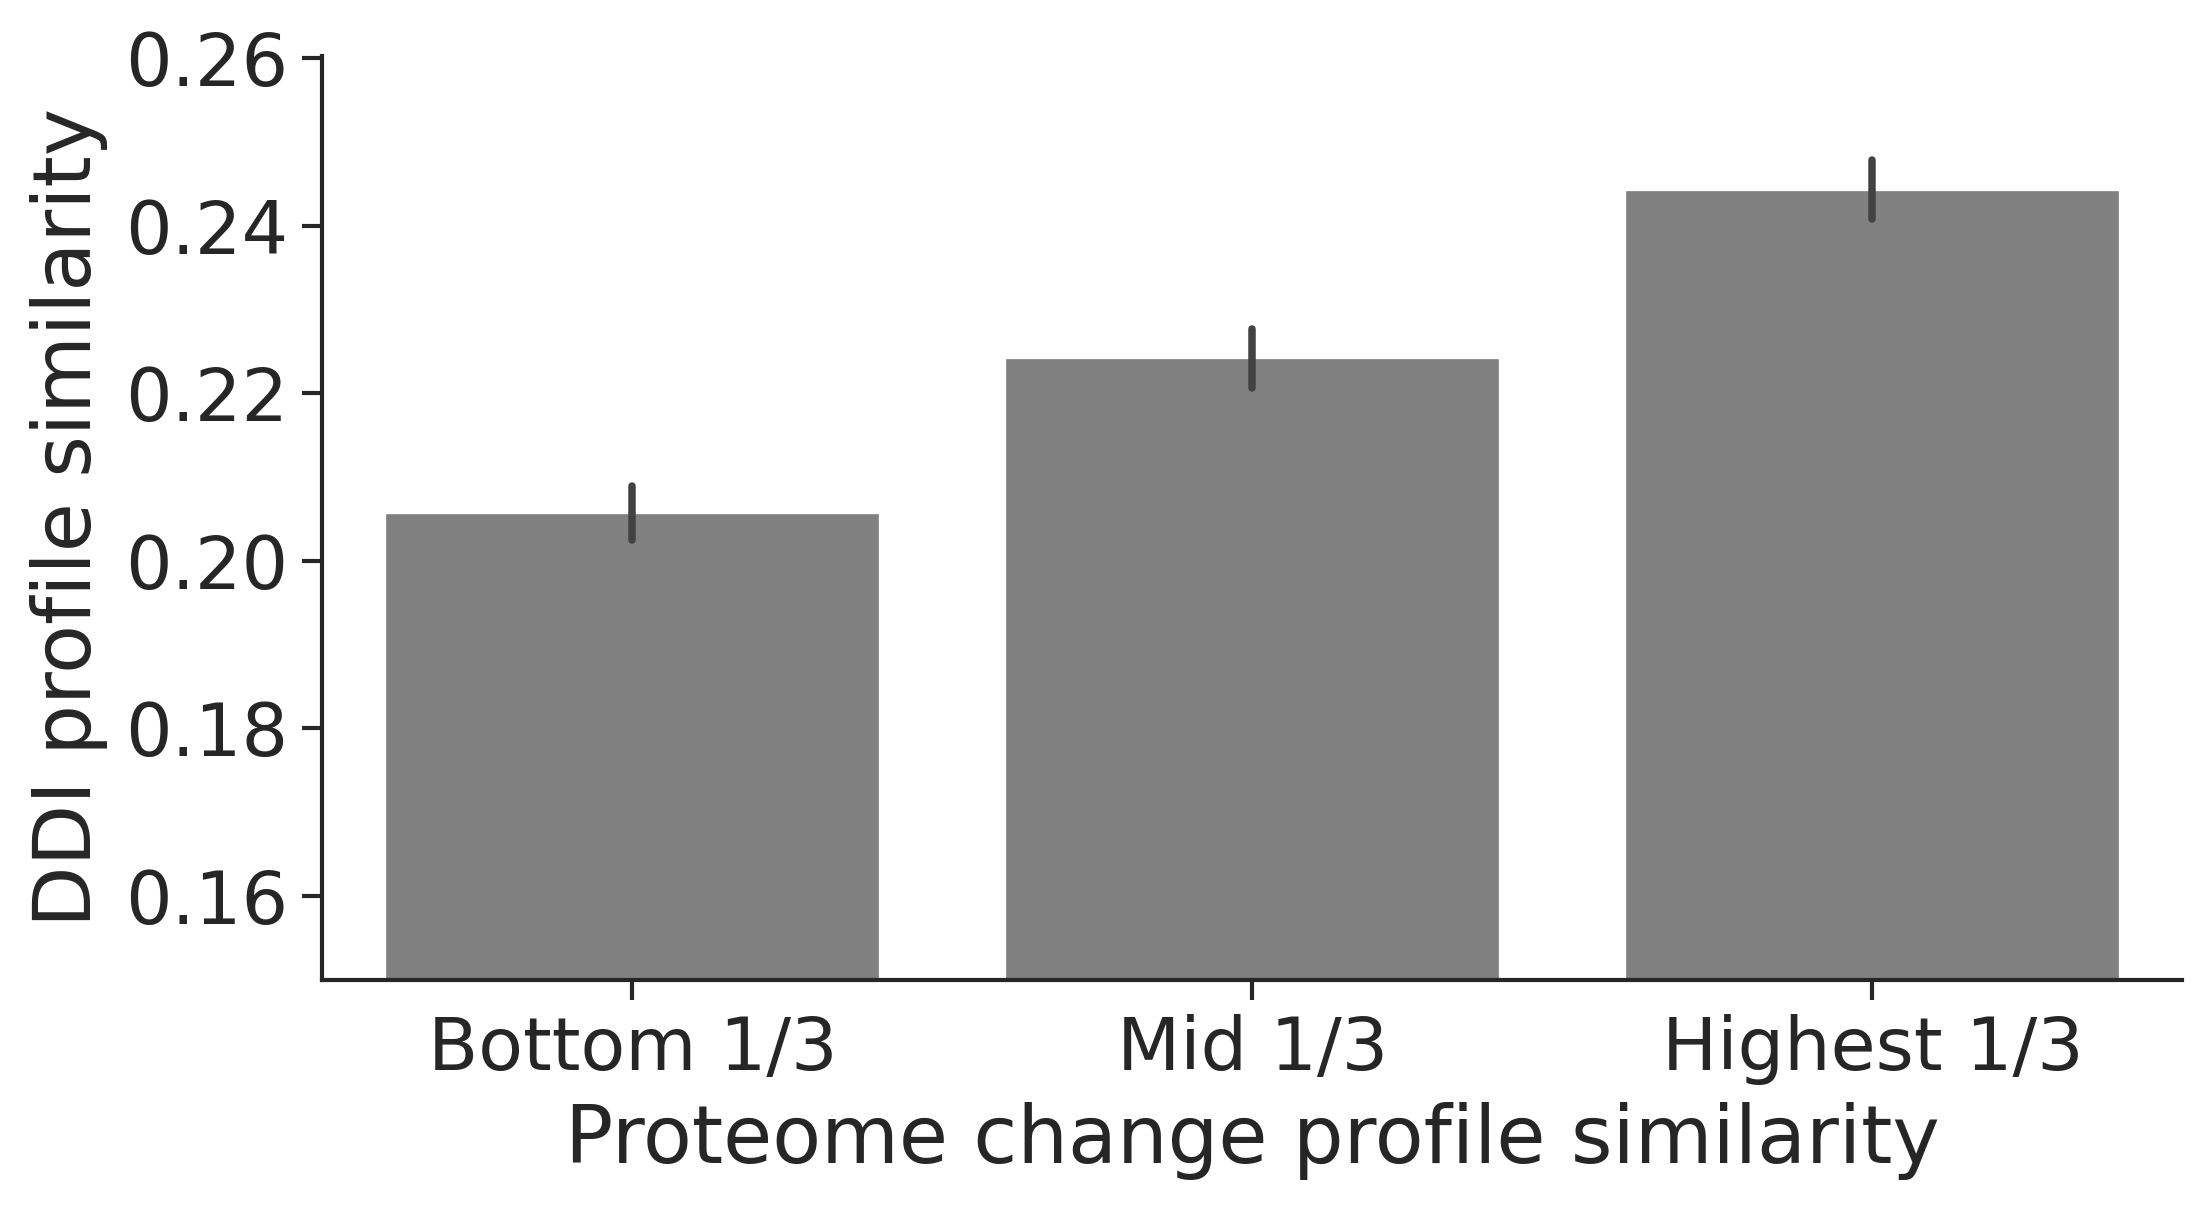

proteome_sims_group
Bottom 1/3     11837
Mid 1/3        11837
Highest 1/3    11837
Name: count, dtype: int64
MannwhitneyuResult(statistic=66950756.0, pvalue=3.45022759364429e-09) MannwhitneyuResult(statistic=66031419.5, pvalue=1.9008883691964816e-14)
bar: [0.20577771728406144, 0.22426574294005758, 0.24436230372827786]
±95 % CI: [[0.2089763160833479, 0.20252409779081074], [0.22767001505748297, 0.2206725394435966], [0.2478736061331211, 0.24077229384995938]]


In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)
ax = sns.barplot(data=plot_data, x="proteome_sims_group", y="ddi_sims", color="gray",)
plt.xlabel("Proteome change profile similarity")
plt.ylabel("DDI profile similarity")
sns.despine()
plt.ylim(0.15)

# plt.savefig("./fig_supp_proteome_sims_ddi_sims_corr.svg", format="svg", dpi=300)
plt.show()

print(plot_data["proteome_sims_group"].value_counts())
print(
    mannwhitneyu(
        plot_data[plot_data["proteome_sims_group"] == "Bottom 1/3"]["ddi_sims"].values,
        plot_data[plot_data["proteome_sims_group"] == "Mid 1/3"]["ddi_sims"].values,
    ),
    mannwhitneyu(
        plot_data[plot_data["proteome_sims_group"] == "Mid 1/3"]["ddi_sims"].values,
        plot_data[plot_data["proteome_sims_group"] == "Highest 1/3"]["ddi_sims"].values,
    )
)

bar_values = [patch.get_height() for patch in ax.patches]

ci_halfwidths = []
for line in ax.lines:
    y_low, y_high = line.get_ydata()
    ci_halfwidths.append([y_high, y_low])

print("bar:", bar_values)
print("±95 % CI:", ci_halfwidths)

Drug and outcome-wise DDI sims

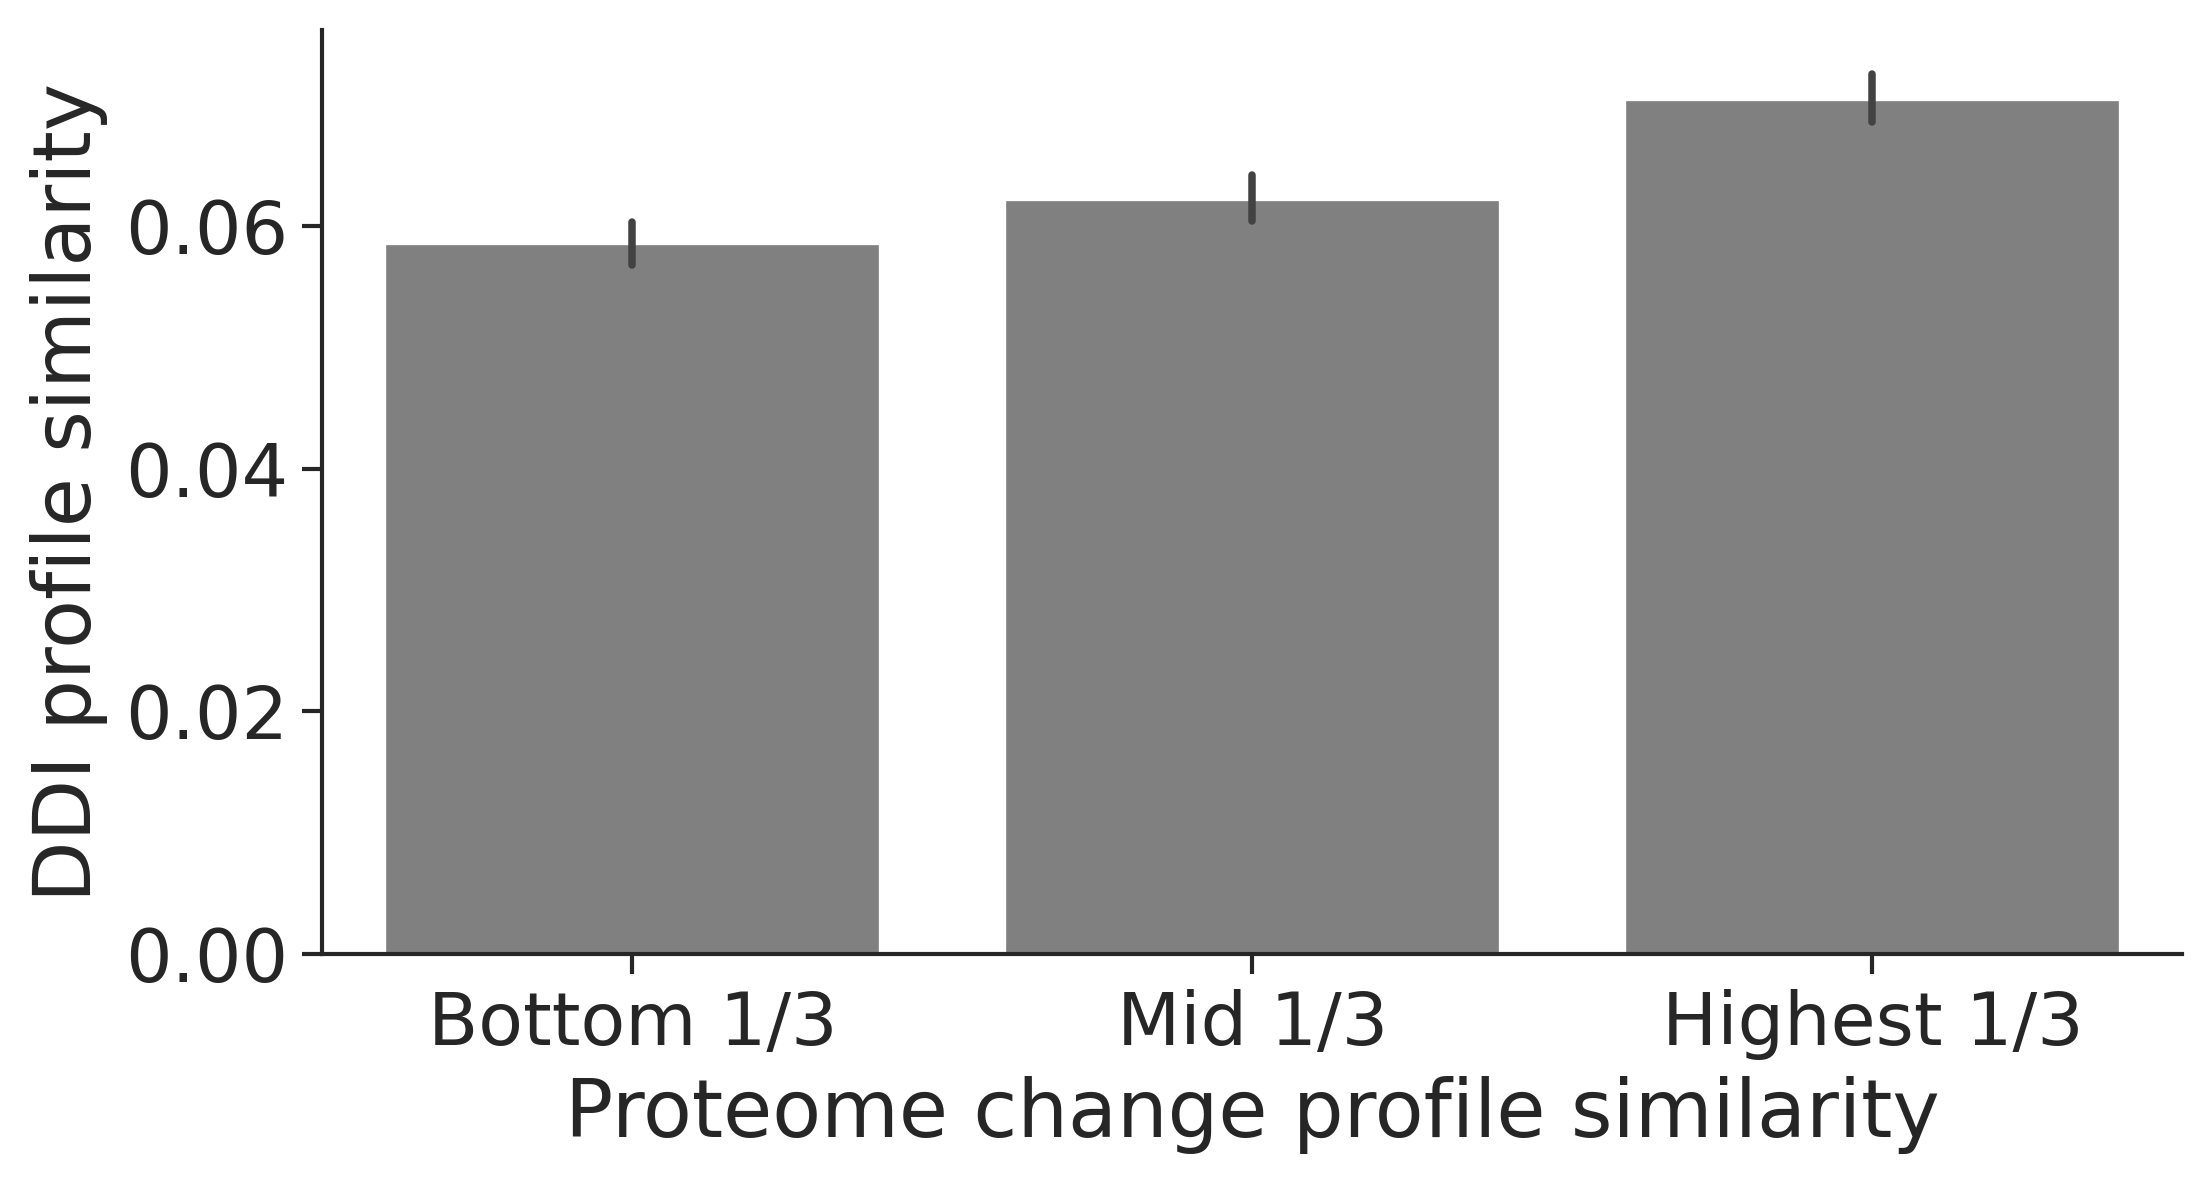

proteome_sims_group
Bottom 1/3     11837
Mid 1/3        11837
Highest 1/3    11837
Name: count, dtype: int64
MannwhitneyuResult(statistic=68964624.5, pvalue=0.0353978860290648) MannwhitneyuResult(statistic=66613724.5, pvalue=3.7753177463411896e-11)
bar: [0.05859654284847961, 0.06225858337341408, 0.07048049286320163]
±95 % CI: [[0.06031387755811981, 0.0567717591707909], [0.06426394436219353, 0.060421427648374625], [0.0725763087379645, 0.06858348659476253]]


In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)
ax = sns.barplot(data=plot_data, x="proteome_sims_group", y="ddi_drug_labels_sims", color="gray",)
plt.xlabel("Proteome change profile similarity")
plt.ylabel("DDI profile similarity")
sns.despine()

# plt.savefig("./fig_supp_proteome_sims_ddi_drug_labels_sims_corr.svg", format="svg", dpi=300)
plt.show()

print(plot_data["proteome_sims_group"].value_counts())
print(
    mannwhitneyu(
        plot_data[plot_data["proteome_sims_group"] == "Bottom 1/3"]["ddi_drug_labels_sims"].values,
        plot_data[plot_data["proteome_sims_group"] == "Mid 1/3"]["ddi_drug_labels_sims"].values,
    ),
    mannwhitneyu(
        plot_data[plot_data["proteome_sims_group"] == "Mid 1/3"]["ddi_drug_labels_sims"].values,
        plot_data[plot_data["proteome_sims_group"] == "Highest 1/3"]["ddi_drug_labels_sims"].values,
    )
)

bar_values = [patch.get_height() for patch in ax.patches]

ci_halfwidths = []
for line in ax.lines:
    y_low, y_high = line.get_ydata()
    ci_halfwidths.append([y_high, y_low])

print("bar:", bar_values)
print("±95 % CI:", ci_halfwidths)

## 2. Off-target info can help explain embedding similarities in cases where targets do not overlap

Find pairs of drugs that have high embedding similarity but no target profile overlap and check their off-target profiles

Check all compounds that have proteomics fp and target info

In [ ]:
cp_mapped_target_profiles = drug_metadata[["cv_target", "tx_target", "targets"]].loc[
    compound_info_mapped["drug_ind"].values, :
].copy()
cp_mapped_target_profiles["all_targets"] = cp_mapped_target_profiles.apply(
    lambda row: 
    set(
        [uniprot_id_to_names[uniprot_id] for uniprot_id in row[2]] 
        if row[2] == row[2] and len(row[2]) > 0 else
        (list(row[1]) if row[1] == row[1] else []) + \
        (list(row[0].split(", ")) if row[0] == row[0] else [])
    ), axis=1
)
cp_mapped_target_profiles.shape

(557, 4)

In [64]:
temp = cp_mapped_target_profiles["all_targets"].apply(lambda st1: cp_mapped_target_profiles["all_targets"].apply(lambda st2: int(len(st1 & st2) > 0)))
temp.values[np.diag_indices_from(temp.values)] = 0
drug_combo_target_profile_sims_01 = pd.melt(
    temp.reset_index(), value_vars=temp.columns, id_vars="index"
).rename(columns={"index":"drug_1_ind", "variable":"drug_2_ind", "value":"target_profile_sim_01"})

cp_mapped_target_profiles["index"] = cp_mapped_target_profiles.index
temp = cp_mapped_target_profiles["index"].apply(
    lambda drug_1_ind: cp_mapped_target_profiles["index"].apply(
        lambda drug_2_ind: embed_sim_mat[drug_1_ind, drug_2_ind]
    )
)
temp.values[np.diag_indices_from(temp.values)] = 0
drug_combo_embed_sims = pd.melt(
    temp.reset_index(), value_vars=temp.columns, id_vars="index"
).rename(columns={"index":"drug_1_ind", "variable":"drug_2_ind", "value":"embed_sim"})

In [65]:
# # NOTE: THIS TAKES A LONG TIME TO RUN, READ FROM SAVED

# def calculate_proteomics_fp_pearson(drug_1_ind, drug_2_ind):
#     drug_1_name = cp_ind_to_name[drug_1_ind]
#     drug_2_name = cp_ind_to_name[drug_2_ind]
#     temp = compound_proteome_fp_mapped.loc[:, [drug_1_name, drug_2_name]].dropna().values
#     r = pearsonr(temp[:, 0], temp[:, 1]).statistic
#     return r

# temp = cp_mapped_target_profiles["index"].apply(
#     lambda drug_1_ind: cp_mapped_target_profiles["index"].apply(
#         lambda drug_2_ind: calculate_proteomics_fp_pearson(drug_1_ind, drug_2_ind)
#     )
# )
# temp.values[np.diag_indices_from(temp.values)] = 0
# drug_combo_proteomics_fp_corr = pd.melt(
#     temp.reset_index(), value_vars=temp.columns, id_vars="index"
# ).rename(columns={"index":"drug_1_ind", "variable":"drug_2_ind", "value":"proteomics_fp_corr"})

# drug_combo_proteomics_fp_corr.to_csv(BASE_DIR + "raw_data/mitchell_2023_proteome_drug_moa/drug_combo_w_target_proteomics_fp_corr_incomplete.csv")

drug_combo_proteomics_fp_corr = pd.read_csv(BASE_DIR + "raw_data/mitchell_2023_proteome_drug_moa/drug_combo_w_target_proteomics_fp_corr_incomplete.csv", index_col=0)

In [66]:
drug_combo_sims = drug_combo_embed_sims.copy()
drug_combo_sims["target_profile_sim_01"] = drug_combo_target_profile_sims_01["target_profile_sim_01"]
drug_combo_sims["proteomics_fp_corr"] = drug_combo_proteomics_fp_corr["proteomics_fp_corr"]

# ensure drugs have target annotations, and are not the same
drug_combo_sims = drug_combo_sims[
    drug_combo_sims["drug_1_ind"].isin(cp_mapped_target_profiles[~(cp_mapped_target_profiles["all_targets"] == set())].index.values) & \
    drug_combo_sims["drug_2_ind"].isin(cp_mapped_target_profiles[~(cp_mapped_target_profiles["all_targets"] == set())].index.values) & \
    (drug_combo_sims["drug_1_ind"] != drug_combo_sims["drug_2_ind"])
]

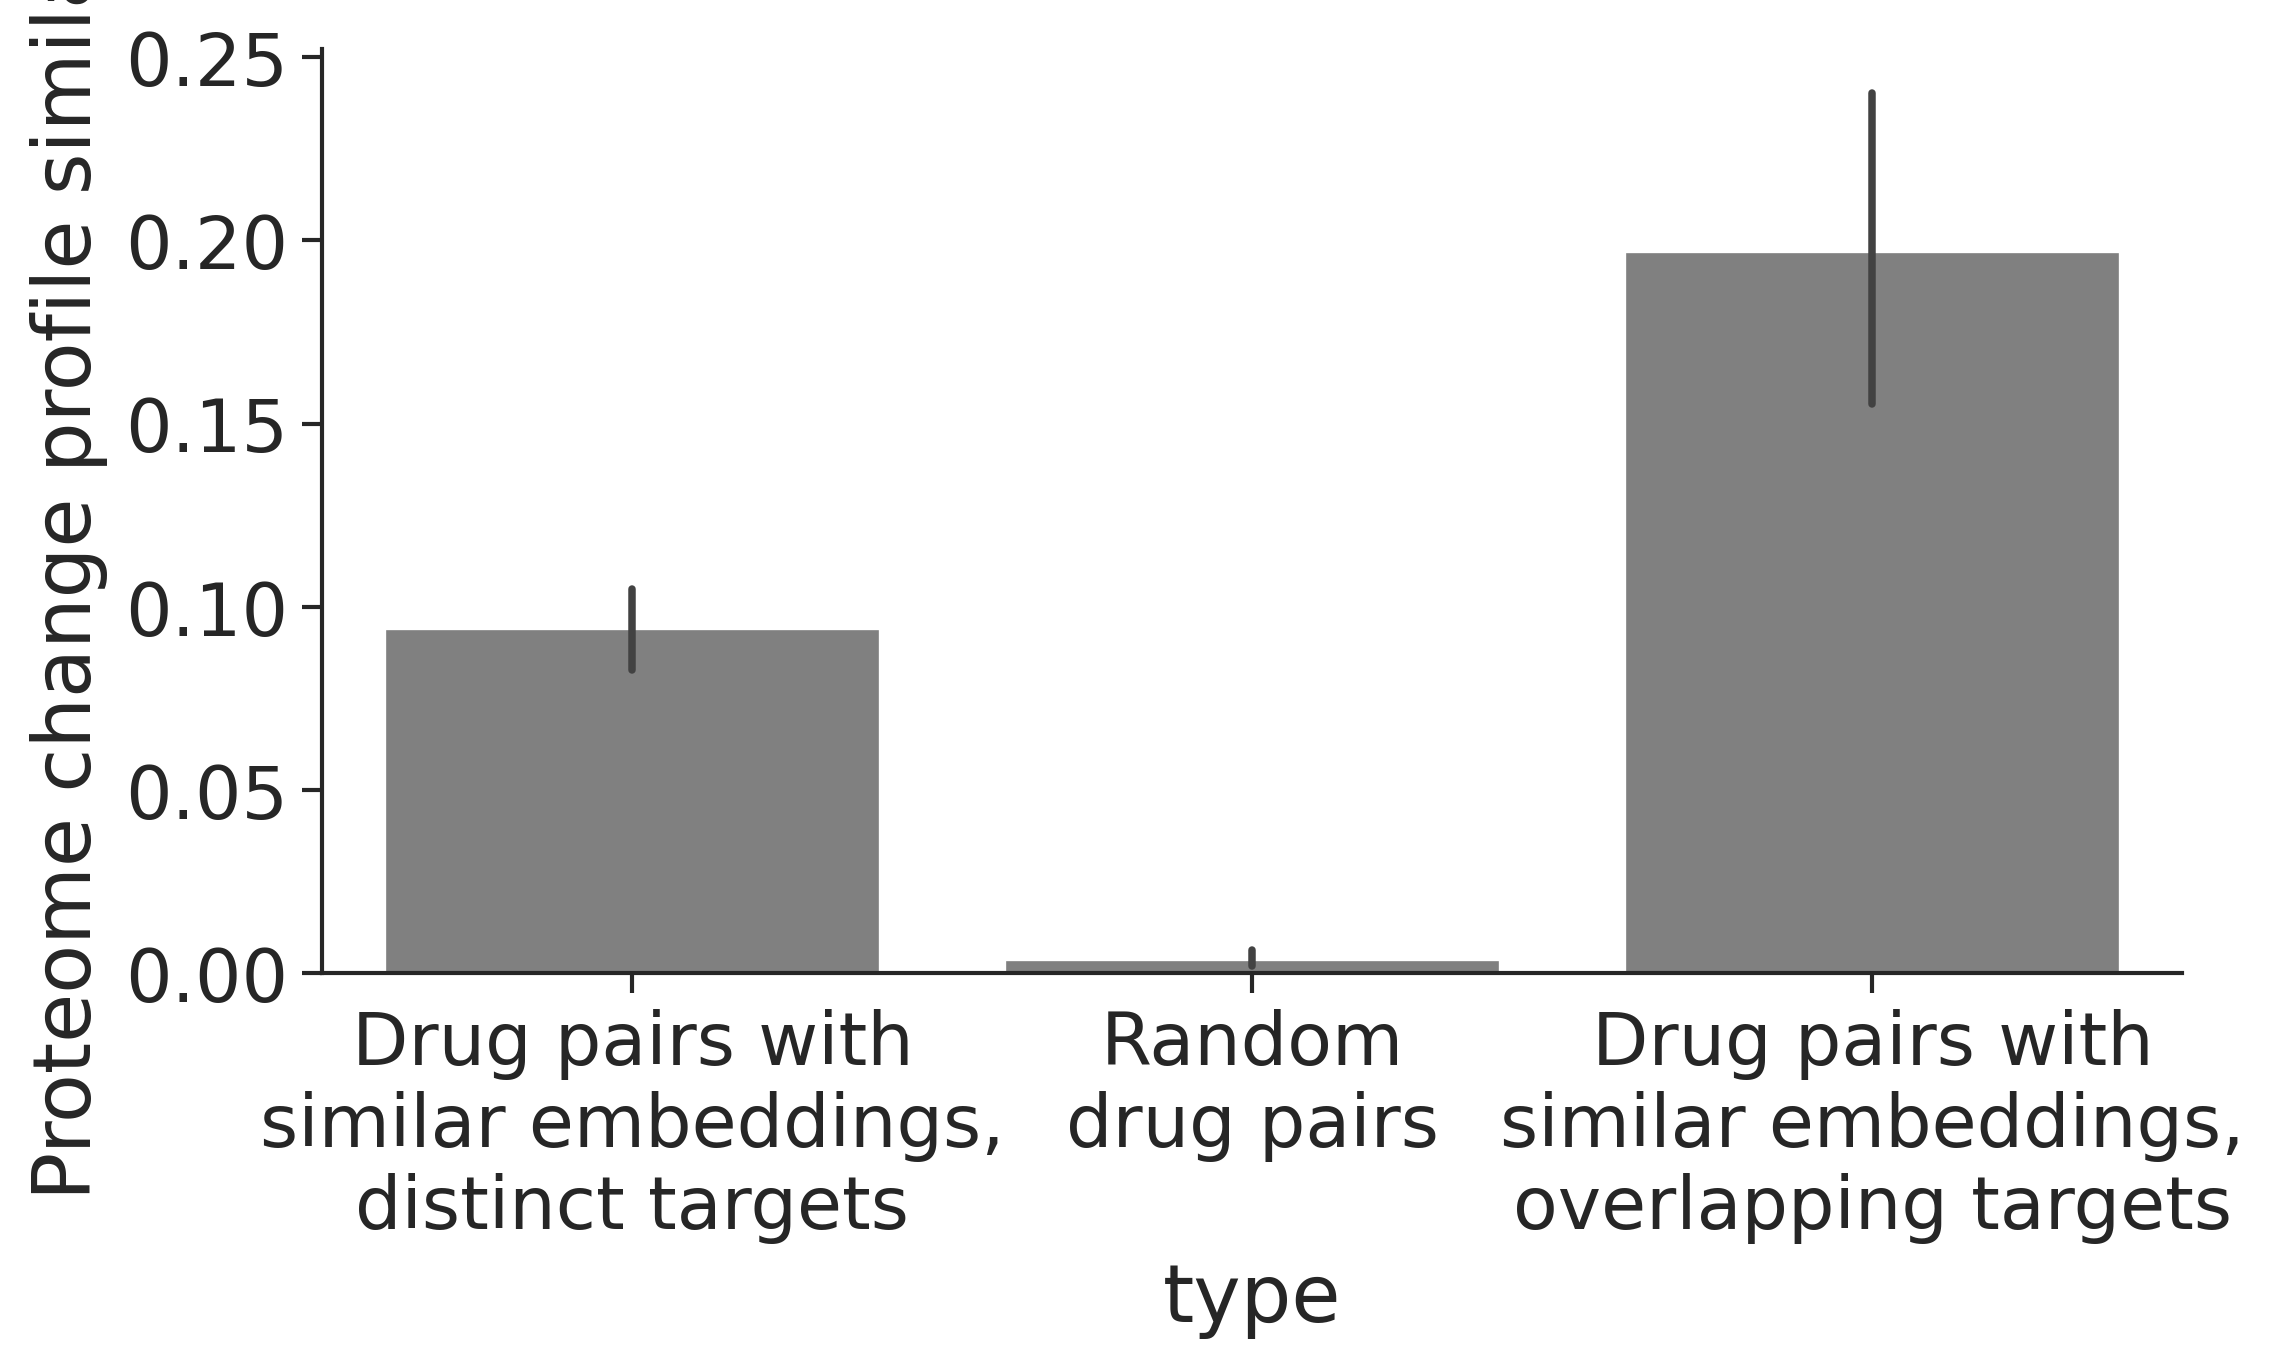

MannwhitneyuResult(statistic=7436455.0, pvalue=4.906047813804426e-59)
bar: [0.09411218248514672, 0.0040166786710932965, 0.19708660743678813]
±95 % CI: [[0.10475071351447501, 0.08273585375964689], [0.006242834790222416, 0.00203735466005343], [0.24013972278571938, 0.155280062345884]]


In [ ]:
plot_data = pd.DataFrame.from_dict({
    "proteomics_fp_corr": 
    drug_combo_sims[
        (drug_combo_sims["embed_sim"] > 0.95) & (drug_combo_sims["target_profile_sim_01"] == 0)
    ]["proteomics_fp_corr"].values.tolist() + \
    np.random.choice(drug_combo_sims[
        drug_combo_sims["drug_1_ind"] != drug_combo_sims["drug_2_ind"]
    ]["proteomics_fp_corr"].values, 10000, replace=False).tolist() + \
    drug_combo_sims[
        (drug_combo_sims["embed_sim"] > 0.95) & (drug_combo_sims["target_profile_sim_01"] > 0)
    ]["proteomics_fp_corr"].values.tolist(),
    "type": 
    ["Drug pairs with\nsimilar embeddings,\ndistinct targets"] * drug_combo_sims[
        (drug_combo_sims["embed_sim"] > 0.95) & (drug_combo_sims["target_profile_sim_01"] == 0)
    ]["proteomics_fp_corr"].shape[0] + \
    ["Random\ndrug pairs"] * 10000 + \
    ["Drug pairs with\nsimilar embeddings,\noverlapping targets"] * drug_combo_sims[
        (drug_combo_sims["embed_sim"] > 0.95) & (drug_combo_sims["target_profile_sim_01"] > 0)
    ]["proteomics_fp_corr"].shape[0],
})

plt.figure(figsize=(8, 4), dpi=300)
ax = sns.set(style="ticks", context="paper", font_scale=2)
ax = sns.barplot(
    plot_data, x="type", y="proteomics_fp_corr", color="gray"
)
plt.ylabel("Proteome change profile similarity")
sns.despine()

# plt.savefig("./fig_supp_proteome_sims_drugs_sim_embeds_dissim_targets.svg", format="svg", dpi=300)
plt.show()

print(
    mannwhitneyu(
    drug_combo_sims[
        (drug_combo_sims["embed_sim"] > 0.95) & (drug_combo_sims["target_profile_sim_01"] == 0)
    ]["proteomics_fp_corr"].values, 
    np.random.choice(drug_combo_sims[drug_combo_sims["drug_1_ind"] != drug_combo_sims["drug_2_ind"]]["proteomics_fp_corr"].values, 10000, replace=False).tolist()
)
)

bar_values = [patch.get_height() for patch in ax.patches]

ci_halfwidths = []
for line in ax.lines:
    y_low, y_high = line.get_ydata()
    ci_halfwidths.append([y_high, y_low])

print("bar:", bar_values)
print("±95 % CI:", ci_halfwidths)